# Load DE genes
Use publication's cell type specific genes

In [1]:
import pandas as pd
import numpy as np
specific_gene = pd.read_excel('GABA_gluta.xlsx', header = 0)
specific_gene.head() # only need Cell Type

# it is a very rough way of doing it
specific_gene['gene'] = specific_gene['gene'].str.upper()

In [2]:
for name, g in specific_gene.groupby(by = 'Celltype')['gene']: # top 1000 enrichmed genes in each cell type
    print(name, len(list(g)))
# this publication produces 1000 top differentially expressed gene for each cell type
# we sought to find what "functions" they are all doing

GABA 1000
gluta 1000


In [3]:
def de_term(ont, specific_gene):
    '''
    find de term per ontology. De term is defined as 1%
    ont: ddot.Ontology
    specific gene: dataframe per with column ['gene, 'Celltype']
    return de_term_dict for each cell type
    '''
    
    
    ont_pro = ont.propagate(direction = 'forward')
    ont_tbl = ont.to_table()
    
    # find background distribution
    all_p = ont_tbl.loc[ont_tbl['EdgeType']== 'Gene-Term'].groupby(by = 'Parent').count()
    all_genes = ont_tbl.loc[ont_tbl['EdgeType']== 'Gene-Term']['Child'].unique()
    
    background_gene_count = pd.DataFrame(index = all_p.index)
    
    # sample 1000 genes for constructing background distribution for each term
    n_iter = 0
    while n_iter < 100:
        # randomly choose 1000 gebe
        rand_index = np.random.choice(len(all_genes), 1000, replace=False)
        rand_genes = all_genes[rand_index]
    
        background_gene_count[n_iter] = (ont_tbl.loc[ont_tbl['Child'].isin(rand_genes)].groupby(by = 'Parent').count()['Child'])
        n_iter+=1
    background_gene_count.fillna(0, inplace = True)
    threshold = background_gene_count.quantile(axis = 1, q = 0.99)
    
    # propagate the cell-type specific genes along ontology, and see what terms are enriched
    de_term_dict = {}
    for name, g in specific_gene.groupby(by = 'Celltype')['gene']: # top 1000 enrichmed genes in each cell type
    
        cell_specific_gene_count = ont_tbl.loc[ont_tbl['Child'].isin(g)].groupby(by = 'Parent').count()['Child'] # each term has how many cell type specific genes
        # how many of them exceed 99 percentile?
        de_term = ont_tbl.loc[ont_tbl['Child'].isin(g)].groupby(by = 'Parent').count()['Child'].ge(threshold)
        de_term_dict[name] = list(de_term.loc[de_term].index)
    return(de_term_dict)

In [4]:
ent_thres = np.arange(start = 0.05, stop = 1, step = 0.05)
data_root = '/cellar/users/hsher/ontoPrune/data/'
import pickle
from ddot import Ontology
def wrapper(e_thres, filename = 'one_percent_term'):
    '''
    run DE term for ontology of different threshold
    '''
    print("running ", e_thres)
    
    # read ontology
    go = Ontology.read_pickle(data_root+'prune_go_{:.2f}'.format(e_thres))
    no_terms = len(go.terms)
    
    dterms = de_term(go, specific_gene)
    no_de_term = [len(dterms[cell]) for cell in dterms.keys()]
    
    # save to file
    with open(data_root+"{}_{:.2f}".format(filename, e_thres), "wb") as fp:   #Pickling
        pickle.dump(dterms, fp)
    
    return(no_terms, no_de_term)

In [5]:
de_term_stat = pd.DataFrame(index = ent_thres, columns = ['total_terms','GABA', 'gluta'])
for e in ent_thres:
    no_terms, no_de_terms = wrapper(e, filename = 'neuron_subtype_term')
    de_term_stat.loc[e] = [no_terms]+no_de_terms

running  0.05
running  0.1
running  0.15000000000000002
running  0.2
running  0.25
running  0.3
running  0.35000000000000003
running  0.4
running  0.45
running  0.5
running  0.55
running  0.6000000000000001
running  0.6500000000000001
running  0.7000000000000001
running  0.7500000000000001
running  0.8
running  0.8500000000000001
running  0.9000000000000001
running  0.9500000000000001


In [6]:
de_term_stat

,total_terms,GABA,gluta
0.05,17158,1170,1498
0.10,17038,1147,1483
0.15,16911,1167,1453
0.20,16760,1145,1502
0.25,16444,1127,1462
0.30,16086,1100,1397
0.35,15538,1083,1427
0.40,14864,1072,1356
0.45,13742,995,1320
0.50,12305,866,1206


In [7]:
de_term_stat.columns

Index(['total_terms', 'GABA', 'gluta'], dtype='object')

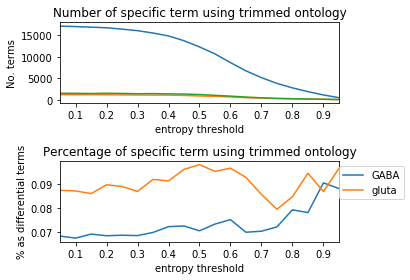

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

f, ax = plt.subplots(2,1)

de_term_stat.plot(ax = ax[0], legend = False)
ax[0].set_xlabel('entropy threshold')
ax[0].set_ylabel('No. terms')
ax[0].set_title('Number of specific term using trimmed ontology')

percentage_term = de_term_stat[['GABA', 'gluta']].div(de_term_stat['total_terms'], axis = 0)
percentage_term.plot(ax = ax[1], legend = False)
ax[1].set_xlabel('entropy threshold')
ax[1].set_ylabel('% as differential terms')
ax[1].set_title('Percentage of specific term using trimmed ontology')
ax[1].legend(bbox_to_anchor=(1.25, 1))

plt.tight_layout()